# Natural Language Processing

In [1]:
# Importing TF and checking the version
import tensorflow as tf

print(tf.__version__)

2.10.1


In [2]:
# Importing helper functions
from DanielBourke_HelperFunctions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Analysing text dataset

In [3]:
# Loading data
import pandas as pd

train_df = pd.read_csv("NLP_text/train.csv")
test_df = pd.read_csv("NLP_text/test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Shuffling training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [5]:
# Checking test dataframe
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# Checking number of training records
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [7]:
# Checking total number of samples
len(train_df), len(test_df)

(7613, 3263)

In [8]:
# Visualising random samples
import random

random_index = random.randint(0, len(train_df) - 5)

for row in train_df_shuffled[["text", "target"]][random_index : random_index + 5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}")
    print("---")

Target: 0 (not real disaster)
Text:
The things we fear most in organizations--fluctuations disturbances imbalances--are the primary sources of creativity. - Margaret Wheatley
---
Target: 0 (not real disaster)
Text:
FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday
---
Target: 0 (not real disaster)
Text:
Am now repped by the fantastic Laura Milne @TheJonesesVoice for all your liguistic needs. And that's some tongue twister tweets
---
Target: 1 (real disaster)
Text:
@KopiteLuke1892 Its broken its fully exploded.
---
Target: 0 (not real disaster)
Text:
Yay for sirens
---


### Creating validation data

In [9]:
# Splitting dataset
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size=0.1, # Allocating 10% to validation data
    random_state=42
)

In [10]:
# Checking dataset length
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [11]:
# Checking the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

### Converting text to numbers

In [12]:
# Using text vectorisation
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens=None,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None,
    output_mode="int",
    output_sequence_length=None,
    pad_to_max_tokens=False
)

In [13]:
# Finding the average number of tokens
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [14]:
# Setting up text vectorisation variables
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode="int",
    output_sequence_length=max_length
)

In [15]:
# Fitting text vectorisation to the training dataset
text_vectorizer.adapt(train_sentences)

In [16]:
# Create a sample sentnence and tokenise it
sample_sentence = "There is a flood in my street"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [17]:
# Tokenising random sentence from the training set
random_sentence = random.choice(train_sentences)
print(
    f"Original text:\n{random_sentence},\ntokenised version:\n{text_vectorizer([random_sentence])}"
)

Original text:
Edwin wow. Crushed.,
tokenised version:
[[  1 970 553   0   0   0   0   0   0   0   0   0   0   0   0]]


In [18]:
# Getting unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

len(words_in_vocab), top_5_words, bottom_5_words

(10000,
 ['', '[UNK]', 'the', 'a', 'in'],
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1'])

### Creating Embedding layer

In [19]:
# Defining the layer
from tensorflow.keras import layers

embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    input_length=max_length
)
embedding

In [20]:
# Get a random sentence
random_sentence = random.choice(train_sentences)
print(
    f"Original text:\n{random_sentence},\nembedded version:"
)

# Embed random sentence
embed_sentence = embedding(text_vectorizer([random_sentence]))
embed_sentence

Original text:
The Pak terrorist who has been caught alive must be tried fast not delayed as KasabWe must send very hard message to Pak instead of Biryani,
embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00326527, -0.00817797,  0.01461886, ..., -0.01599415,
          0.01874011,  0.01582913],
        [-0.03426911, -0.00376127, -0.02496681, ...,  0.0427187 ,
         -0.03176917,  0.04822988],
        [-0.02119344, -0.01479244,  0.00993613, ...,  0.02746631,
          0.03505886, -0.03882639],
        ...,
        [ 0.04498056, -0.04354383, -0.01037494, ...,  0.0176453 ,
          0.032415  ,  0.04745475],
        [ 0.00133324,  0.04248324, -0.00118713, ..., -0.03938041,
          0.03681395,  0.04983443],
        [-0.04643248,  0.00022953, -0.03369727, ..., -0.01626524,
         -0.01432688,  0.00503927]]], dtype=float32)>

In [21]:
# Checking single token's embedding
embed_sentence[0][0], embed_sentence[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.00326527, -0.00817797,  0.01461886,  0.00886587,  0.02068162,
        -0.03897413,  0.00342506, -0.00036552, -0.04472829,  0.01619818,
        -0.04360384, -0.01073884,  0.01733044, -0.04707032, -0.0385352 ,
        -0.02642183, -0.0343307 , -0.02304293, -0.02311422, -0.01936759,
         0.00119736,  0.02465841, -0.04964794,  0.03368571,  0.02426518,
        -0.02993971, -0.04314683,  0.00483416, -0.0392665 ,  0.01123195,
        -0.04018022, -0.01217418,  0.01607722,  0.01499415,  0.01174126,
         0.02360303,  0.01317627, -0.00841619, -0.00974532, -0.04491959,
        -0.03423746,  0.00694048,  0.01682514,  0.0321232 , -0.03170371,
         0.02058133,  0.02117027, -0.0289373 , -0.02254883, -0.03639784,
        -0.0359205 ,  0.00954002, -0.04463658, -0.02411673,  0.03123839,
         0.03743069,  0.01038805, -0.02703222,  0.00864452,  0.04613056,
        -0.04184423,  0.01197431,  0.030732  , -0.02826252, -0.00770863,
  

### Building base model

In [22]:
# Using SKLearn to build base model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenisation and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # Convert words to numbers
    ("clf", MultinomialNB()) # Model the text
])

# Fit the pipeline to training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluating baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Achieved accuracy: {baseline_score * 100:.2f}%")

Achieved accuracy: 79.27%


In [24]:
# Making predictions
baseline_predictions = model_0.predict(val_sentences)
baseline_predictions[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

### Function to evaluate model performance

In [25]:
# Importing SKLearn functions
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Developing function to evaluate accuracy, precision, recall and F1 scor
def calculate_results(y_true, y_pred):
    """
    Evaluate binary classification model
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and F1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    return model_results

In [26]:
# Getting baseline results
baseline_results = calculate_results(
    y_true=val_labels,
    y_pred=baseline_predictions
)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: a simple dense model

In [27]:
# Creating tensorboard callback
from DanielBourke_HelperFunctions import create_tensorboard_callback

# Creating log directory
SAVE_DIR = "model_logs"

In [28]:
# Building model with Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs) # Turn the input text into numbers
x = embedding(x) # Create embedding of numberised inputs
x = layers.GlobalAveragePooling1D()(x) # Condence the feature vector
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [29]:
# Getting model summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [30]:
# Compiling model
model_1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [31]:
# Fitting the model
history_1 = model_1.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_1_dense"
    )]
)

Saving TensorBoard log files to: model_logs/model_1_dense/20230117-144615
Epoch 1/5
215/215 [==============================] - 6s 22ms/step - loss: 0.6121 - accuracy: 0.6968 - val_loss: 0.5348 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4419 - accuracy: 0.8184 - val_loss: 0.4691 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3468 - accuracy: 0.8606 - val_loss: 0.4576 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2846 - accuracy: 0.8895 - val_loss: 0.4652 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.2381 - accuracy: 0.9120 - val_loss: 0.4807 - val_accuracy: 0.7887


In [32]:
# Checking the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4807 - accuracy: 0.7887


[0.4806691110134125, 0.7887139320373535]

In [33]:
# Making predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [34]:
# First 10 predictions
model_1_pred_probs[:10]

array([[0.3341781 ],
       [0.7539585 ],
       [0.99782854],
       [0.12091462],
       [0.09899848],
       [0.93790734],
       [0.9062346 ],
       [0.9936596 ],
       [0.9634924 ],
       [0.2944509 ]], dtype=float32)

In [35]:
# Converting model predictions to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [36]:
# Calculating model 1 results
model_1_results = calculate_results(
    y_true=val_labels,
    y_pred=model_1_preds
)
model_1_results

{'accuracy': 78.87139107611549,
 'precision': 0.7948464726843409,
 'recall': 0.7887139107611548,
 'f1': 0.7853694687698636}

In [37]:
# Retrieving baseline results
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [38]:
# Comparing model results
import numpy as np

np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Visualising learned embeddings

In [39]:
# Getting vocabulary from the text vectorisation layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [40]:
# Checking model 1 details
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [41]:
# Getting the weights
embed_weights = model_1.get_layer("embedding").get_weights()
embed_weights, embed_weights[0].shape

([array([[ 2.6767540e-03, -3.2777602e-03,  4.5976691e-02, ...,
           5.5052131e-02, -1.6638136e-02,  1.2244918e-02],
         [-5.3494737e-02,  2.8274154e-02,  2.5087100e-02, ...,
          -8.2938997e-03, -1.2823562e-02,  3.0468582e-05],
         [-1.5043786e-02,  5.3968546e-03,  2.7731257e-02, ...,
           4.8143580e-04,  5.3653554e-03,  3.6919019e-03],
         ...,
         [ 2.9636178e-02,  1.9981328e-02,  2.8004497e-04, ...,
           4.3947946e-02, -1.5317760e-02,  2.6961081e-03],
         [-3.0326257e-02, -1.3019651e-03,  5.0665926e-02, ...,
           6.0863372e-02, -5.9041396e-02,  8.6783441e-03],
         [-5.5409823e-02,  1.1034158e-01,  7.3128663e-02, ...,
           8.5190937e-02, -6.7571141e-02, -2.7192261e-02]], dtype=float32)],
 (10000, 128))

In [42]:
# Creating embedding files (sample from TF Word Embedding documentation)
import io

out_v = io.open("vectors.tsv", "w", encoding="utf-8")
out_m = io.open("metadata.tsv", "w", encoding="utf-8")

for index, word in enumerate(words_in_vocab):
    if index == 0:
        continue # Skip 0, as it's a padding
    vec = embed_weights[0][index]
    out_v.write("\t".join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")

out_v.close()
out_m.close()

Generated vectors.tsv and metadata.tsv can be uploaded into Tensorflow Embedding Projector tool at https://projector.tensorflow.org/ to visualise weights in 3D space.

### Model 2 - RNN (Recurrent Neural Network) with LSTM (Long Short-Term Memory)

In [43]:
# CReating an RNN model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # Sequences required when you stack LSTM layers
# print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [44]:
# Checking model's summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [45]:
# Compiling the model
model_2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [46]:
# Fittting the model
history_2 = model_2.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_2_LSTM"
    )]
)

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230117-144640
Epoch 1/5
215/215 [==============================] - 10s 28ms/step - loss: 0.2223 - accuracy: 0.9215 - val_loss: 0.5274 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.1563 - accuracy: 0.9429 - val_loss: 0.6688 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.1308 - accuracy: 0.9495 - val_loss: 0.8233 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.1075 - accuracy: 0.9596 - val_loss: 0.8376 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0844 - accuracy: 0.9669 - val_loss: 0.9954 - val_accuracy: 0.7690


In [47]:
# Meking predictions
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[4.2517679e-03],
       [7.5846618e-01],
       [9.9988163e-01],
       [2.5216393e-02],
       [4.0567457e-04],
       [9.9919766e-01],
       [3.9032951e-01],
       [9.9992549e-01],
       [9.9986601e-01],
       [5.4421079e-01]], dtype=float32)

In [48]:
# Converting pred probs to label format
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [49]:
#Calculate model 2 results
model_2_results = calculate_results(
    y_true=val_labels,
    y_pred=model_2_preds
)
model_2_results

{'accuracy': 76.9028871391076,
 'precision': 0.7711368167182066,
 'recall': 0.7690288713910761,
 'f1': 0.7666669868908192}

### Model 3 - RNN with GRU (gated recurrent unit)

In [50]:
# Building the model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True)(x) # Sequences, if GRU are stuck on each other
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x) # If we want to consolidate GRU layer with sequences
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [51]:
# Getting model summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [52]:
# Compiling the model
model_3.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [53]:
# Fitting the model
history_3 = model_3.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_3_GRU"
    )]
)

Saving TensorBoard log files to: model_logs/model_3_GRU/20230117-144712
Epoch 1/5
215/215 [==============================] - 10s 28ms/step - loss: 0.1552 - accuracy: 0.9371 - val_loss: 0.7951 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0822 - accuracy: 0.9688 - val_loss: 0.8613 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0695 - accuracy: 0.9742 - val_loss: 1.0881 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0618 - accuracy: 0.9731 - val_loss: 0.8623 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0543 - accuracy: 0.9769 - val_loss: 1.2238 - val_accuracy: 0.7717


In [54]:
# Meking predictions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs

24/24 [==============================] - 1s 4ms/step


array([[2.18061241e-03],
       [6.28073812e-01],
       [9.99931395e-01],
       [1.77777320e-01],
       [7.85981974e-05],
       [9.99894738e-01],
       [7.83210039e-01],
       [9.99971390e-01],
       [9.99941826e-01],
       [9.95610654e-01],
       [2.11663457e-04],
       [9.86105263e-01],
       [2.61931971e-04],
       [1.62298679e-01],
       [7.24547062e-05],
       [3.28263524e-03],
       [4.43045923e-04],
       [3.24096705e-04],
       [6.54874593e-02],
       [9.99921918e-01],
       [9.99978542e-01],
       [3.75662385e-05],
       [9.99355972e-01],
       [6.70541264e-03],
       [9.99959052e-01],
       [9.99956846e-01],
       [2.06564227e-03],
       [4.96006629e-04],
       [2.42066861e-04],
       [6.77800477e-01],
       [9.99692321e-01],
       [1.51984976e-03],
       [3.45256738e-02],
       [1.46777101e-03],
       [7.87342548e-01],
       [2.42188275e-01],
       [9.99915242e-01],
       [3.45686972e-01],
       [4.43611369e-02],
       [9.99960303e-01],


In [55]:
# Converting model 3 pred probs to label format
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [56]:
# Calculate model 3 results
model_3_results = calculate_results(
    y_true=val_labels,
    y_pred=model_3_preds
)
model_3_results

{'accuracy': 77.16535433070865,
 'precision': 0.7717840407633899,
 'recall': 0.7716535433070866,
 'f1': 0.7705026760144871}

### Model 4 - Bidirectional RNN

In [57]:
# Create a model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidir")

In [58]:
# Checking model details
model_4.summary()

Model: "model_4_bidir"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
N

In [59]:
# Compiling the model
model_4.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [60]:
# Fitting the model
history_4 = model_4.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_4_bidir"
    )]
)

Saving TensorBoard log files to: model_logs/model_4_bidir/20230117-144743
Epoch 1/5
215/215 [==============================] - 14s 33ms/step - loss: 0.1111 - accuracy: 0.9664 - val_loss: 1.0688 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0538 - accuracy: 0.9774 - val_loss: 1.2419 - val_accuracy: 0.7533
Epoch 3/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0490 - accuracy: 0.9777 - val_loss: 1.2073 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0420 - accuracy: 0.9807 - val_loss: 1.4051 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0393 - accuracy: 0.9816 - val_loss: 1.1991 - val_accuracy: 0.7703


In [61]:
# Making predictions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[1.4363564e-02],
       [8.1049281e-01],
       [9.9998158e-01],
       [2.5529242e-01],
       [6.3961175e-05],
       [9.9976748e-01],
       [7.1143770e-01],
       [9.9998945e-01],
       [9.9997586e-01],
       [9.7562039e-01]], dtype=float32)

In [62]:
# Adjusting model's probs to the label format
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [63]:
# Checking results of predictions
model_4_results = calculate_results(
    y_true=val_labels,
    y_pred=model_4_preds
)
model_4_results

{'accuracy': 77.03412073490814,
 'precision': 0.7723473976820748,
 'recall': 0.7703412073490814,
 'f1': 0.7680604812955161}

### Model 5 - Conv1D

In [64]:
# Testing embedding layer
from tensorflow.keras import layers

embedding_test = embedding(text_vectorizer("This is a test sentence"))
# print(embedding_test.shape)
embedding_test = tf.expand_dims(embedding_test, axis=0)
# print(embedding_test.shape)
conv_1d = layers.Conv1D(
    filters=32,
    kernel_size=5,
    activation="relu",
    padding="valid"
)
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

### Model 5 - 1D Convolutional Network layer

In [65]:
# Creating a model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(
    filters=64,
    kernel_size=5,
    strides=1,
    activation="relu",
    padding="valid"
)(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_conv1d")

In [66]:
# Checking model details
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [67]:
# Compiling the model
model_5.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [68]:
# Fitting the model
history_5 = model_5.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_5_conv1d"
    )]
)

Saving TensorBoard log files to: model_logs/model_5_conv1d/20230117-144821
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.1201 - accuracy: 0.9618 - val_loss: 0.9034 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0776 - accuracy: 0.9705 - val_loss: 1.0078 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0614 - accuracy: 0.9761 - val_loss: 1.1213 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0540 - accuracy: 0.9775 - val_loss: 1.1958 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0528 - accuracy: 0.9791 - val_loss: 1.2641 - val_accuracy: 0.7638


In [69]:
# Making predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[5.5975154e-02],
       [9.3387508e-01],
       [9.9985701e-01],
       [6.2383004e-02],
       [4.0971180e-08],
       [9.7855866e-01],
       [9.7411549e-01],
       [9.9995136e-01],
       [9.9999928e-01],
       [7.8184485e-01]], dtype=float32)

In [70]:
# Converting probs into label format
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [71]:
# Evaluating model's predictions
model_5_results = calculate_results(
    y_true=val_labels,
    y_pred=model_5_preds
)
model_5_results

{'accuracy': 76.37795275590551,
 'precision': 0.766310461192351,
 'recall': 0.7637795275590551,
 'f1': 0.7610762606610089}

### Model 6 - TensorflowHub pretrained model

In [72]:
# Reusing USE (Universal Sentence Encoder) model
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([
    sample_sentence,
    "When you apple USE to text, it converts it into numbers"
])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01602832  0.01068848  0.02425467 -0.01405769  0.01434426  0.08292625
  0.01963372  0.06160142 -0.00352702 -0.01216412  0.00978647 -0.01248495
  0.01232345  0.09748451  0.06141113 -0.03728353  0.01860884 -0.04669856
  0.00413913 -0.06363907 -0.02469898  0.02713691  0.02284444 -0.00210026
 -0.00630592 -0.03964961  0.02220404  0.00115077 -0.03132177  0.00119527
 -0.0401255   0.04561892 -0.01530598 -0.00175918  0.02173131 -0.08450424
  0.03340026  0.04604554 -0.0248025  -0.08681665  0.00702694 -0.00770478
 -0.01434539  0.07814164 -0.10676058 -0.05152997 -0.00858155 -0.03232232
 -0.03871097  0.02581467], shape=(50,), dtype=float32)


In [73]:
# Sampling shape
embed_samples[0].shape

TensorShape([512])

In [74]:
# Creating layer with USE pretrained model
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False,
    name="USE"
)

In [75]:
# Building a new model with pretrained layer
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    # layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_use")

In [76]:
# Compiling the model
model_6.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [77]:
# Fitting the model
history_6 = model_6.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_6_use"
    )]
)

Saving TensorBoard log files to: model_logs/model_6_use/20230117-144908
Epoch 1/5
215/215 [==============================] - 9s 17ms/step - loss: 0.6495 - accuracy: 0.7268 - val_loss: 0.6130 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.5822 - accuracy: 0.7846 - val_loss: 0.5634 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.5391 - accuracy: 0.7936 - val_loss: 0.5319 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.5105 - accuracy: 0.7978 - val_loss: 0.5110 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4902 - accuracy: 0.7992 - val_loss: 0.4964 - val_accuracy: 0.7887


In [78]:
# Checking the model details
model_6.summary()

Model: "model_6_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


In [79]:
# Making predictions
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 16ms/step


array([[0.35497832],
       [0.66525245],
       [0.85687435],
       [0.35462275],
       [0.639239  ],
       [0.7456621 ],
       [0.8292034 ],
       [0.837728  ],
       [0.76416767],
       [0.19532351]], dtype=float32)

In [80]:
# Converting prediction probs into label format
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [81]:
# Calculating model's performance metrics
model_6_results = calculate_results(
    y_true=val_labels,
    y_pred=model_6_preds
)
model_6_results

{'accuracy': 78.87139107611549,
 'precision': 0.789001261975436,
 'recall': 0.7887139107611548,
 'f1': 0.7876955870597856}

### Model 7 - Pretrained USE with 10% of training data

In [82]:
## THIS IS WRONG WAY TO SPLIT, because of potential data leak,
##  i.e. some data may end up in validation seubset

# Creating subset of 10% training data
train_data_10p = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10p = train_data_10p["text"].to_list()
train_labels_10p = train_data_10p["target"].to_list()
len(train_sentences_10p), len(train_labels_10p)

(761, 761)

In [83]:
## MAKING A BETTER SPLIT

# Creating 10% subset
train_10p_split = int(0.1 * len(train_sentences))
train_sentences_10p = train_sentences[:train_10p_split]
train_labels_10p = train_labels[:train_10p_split]
len(train_sentences_10p), len(train_labels_10p)

(685, 685)

In [84]:
# Checking the length of original dataset
len(train_df_shuffled)

7613

In [85]:
# Checking the number of targets - 10%
train_data_10p["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [86]:
# Checking the number of targets - Full set
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [87]:
# Cloning model 6
model_7 = tf.keras.models.clone_model(model_6)

# Compiling the model
model_7.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Checking the model details
model_7.summary()

Model: "model_6_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


In [88]:
# Fitting the model
history_7 = model_7.fit(
    train_sentences_10p,
    train_labels_10p,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_7_use"
    )]
)

Saving TensorBoard log files to: model_logs/model_7_use/20230117-144944
Epoch 1/5
22/22 [==============================] - 6s 71ms/step - loss: 0.6852 - accuracy: 0.6029 - val_loss: 0.6822 - val_accuracy: 0.6535
Epoch 2/5
22/22 [==============================] - 1s 35ms/step - loss: 0.6722 - accuracy: 0.7285 - val_loss: 0.6732 - val_accuracy: 0.7034
Epoch 3/5
22/22 [==============================] - 1s 36ms/step - loss: 0.6606 - accuracy: 0.7562 - val_loss: 0.6645 - val_accuracy: 0.7283
Epoch 4/5
22/22 [==============================] - 1s 31ms/step - loss: 0.6495 - accuracy: 0.7766 - val_loss: 0.6561 - val_accuracy: 0.7441
Epoch 5/5
22/22 [==============================] - 1s 28ms/step - loss: 0.6387 - accuracy: 0.7971 - val_loss: 0.6484 - val_accuracy: 0.7467


In [89]:
# Making predictions
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 12ms/step


array([[0.45520055],
       [0.5080701 ],
       [0.5653684 ],
       [0.46164846],
       [0.49443656],
       [0.53588665],
       [0.5401494 ],
       [0.5295273 ],
       [0.53797776],
       [0.42686749]], dtype=float32)

In [90]:
# Converting pred probs to label format
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [91]:
# Evaluating model predictions
model_7_results = calculate_results(
    y_true=val_labels,
    y_pred=model_7_preds
)
model_7_results

{'accuracy': 74.67191601049869,
 'precision': 0.7613282978891178,
 'recall': 0.7467191601049868,
 'f1': 0.7384717304023649}

### Comparing performance of each model

In [92]:
# Combining model results into a single dataframe
all_model_results = pd.DataFrame({
    "0_baseline": baseline_results,
    "1_simple_dense": model_1_results,
    "2_lstm": model_2_results,
    "3_gru": model_3_results,
    "4_bidirectional": model_4_results,
    "5_conv1d": model_5_results,
    "6_tfhub_use": model_6_results,
    "7_tfhub_use10p": model_7_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.871391,0.794846,0.788714,0.785369
2_lstm,76.902887,0.771137,0.769029,0.766667
3_gru,77.165354,0.771784,0.771654,0.770503
4_bidirectional,77.034121,0.772347,0.770341,0.768060
5_conv1d,76.377953,0.766310,0.763780,0.761076
6_tfhub_use,78.871391,0.789001,0.788714,0.787696
7_tfhub_use10p,74.671916,0.761328,0.746719,0.738472


In [93]:
# Adjusting accuracy scale
all_model_results["accuracy"] = all_model_results["accuracy"] / 100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.788714,0.794846,0.788714,0.785369
2_lstm,0.769029,0.771137,0.769029,0.766667
3_gru,0.771654,0.771784,0.771654,0.770503
4_bidirectional,0.770341,0.772347,0.770341,0.768060
5_conv1d,0.763780,0.766310,0.763780,0.761076
6_tfhub_use,0.788714,0.789001,0.788714,0.787696
7_tfhub_use10p,0.746719,0.761328,0.746719,0.738472


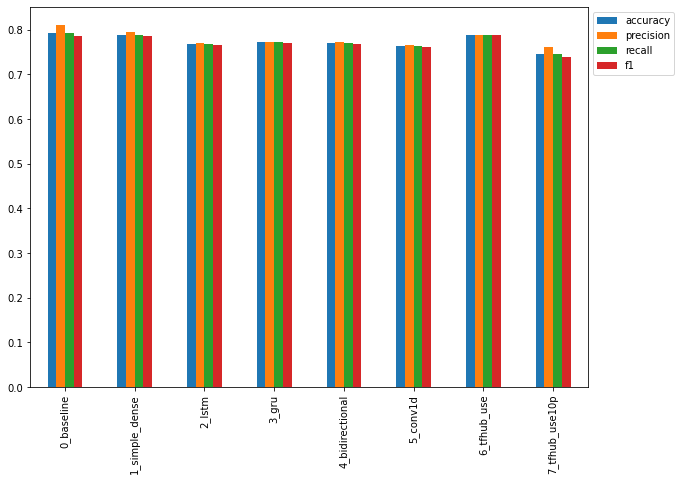

In [94]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<AxesSubplot:>

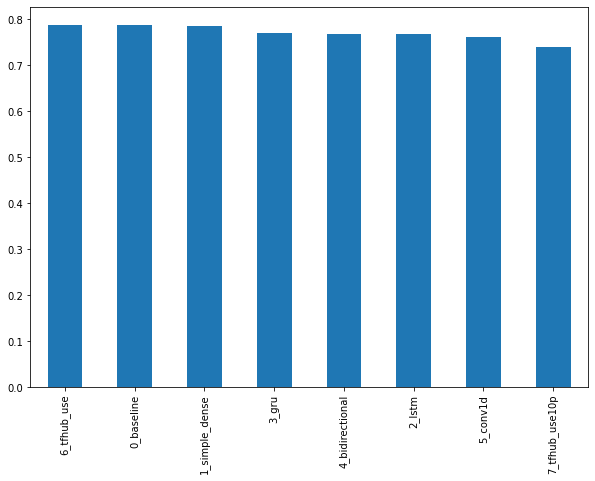

In [95]:
# Visualising F1 score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

### TensorBoard visualisation

In [96]:
# Local execution of TensorBoard
# !tensorboard --logdir ./model_logs

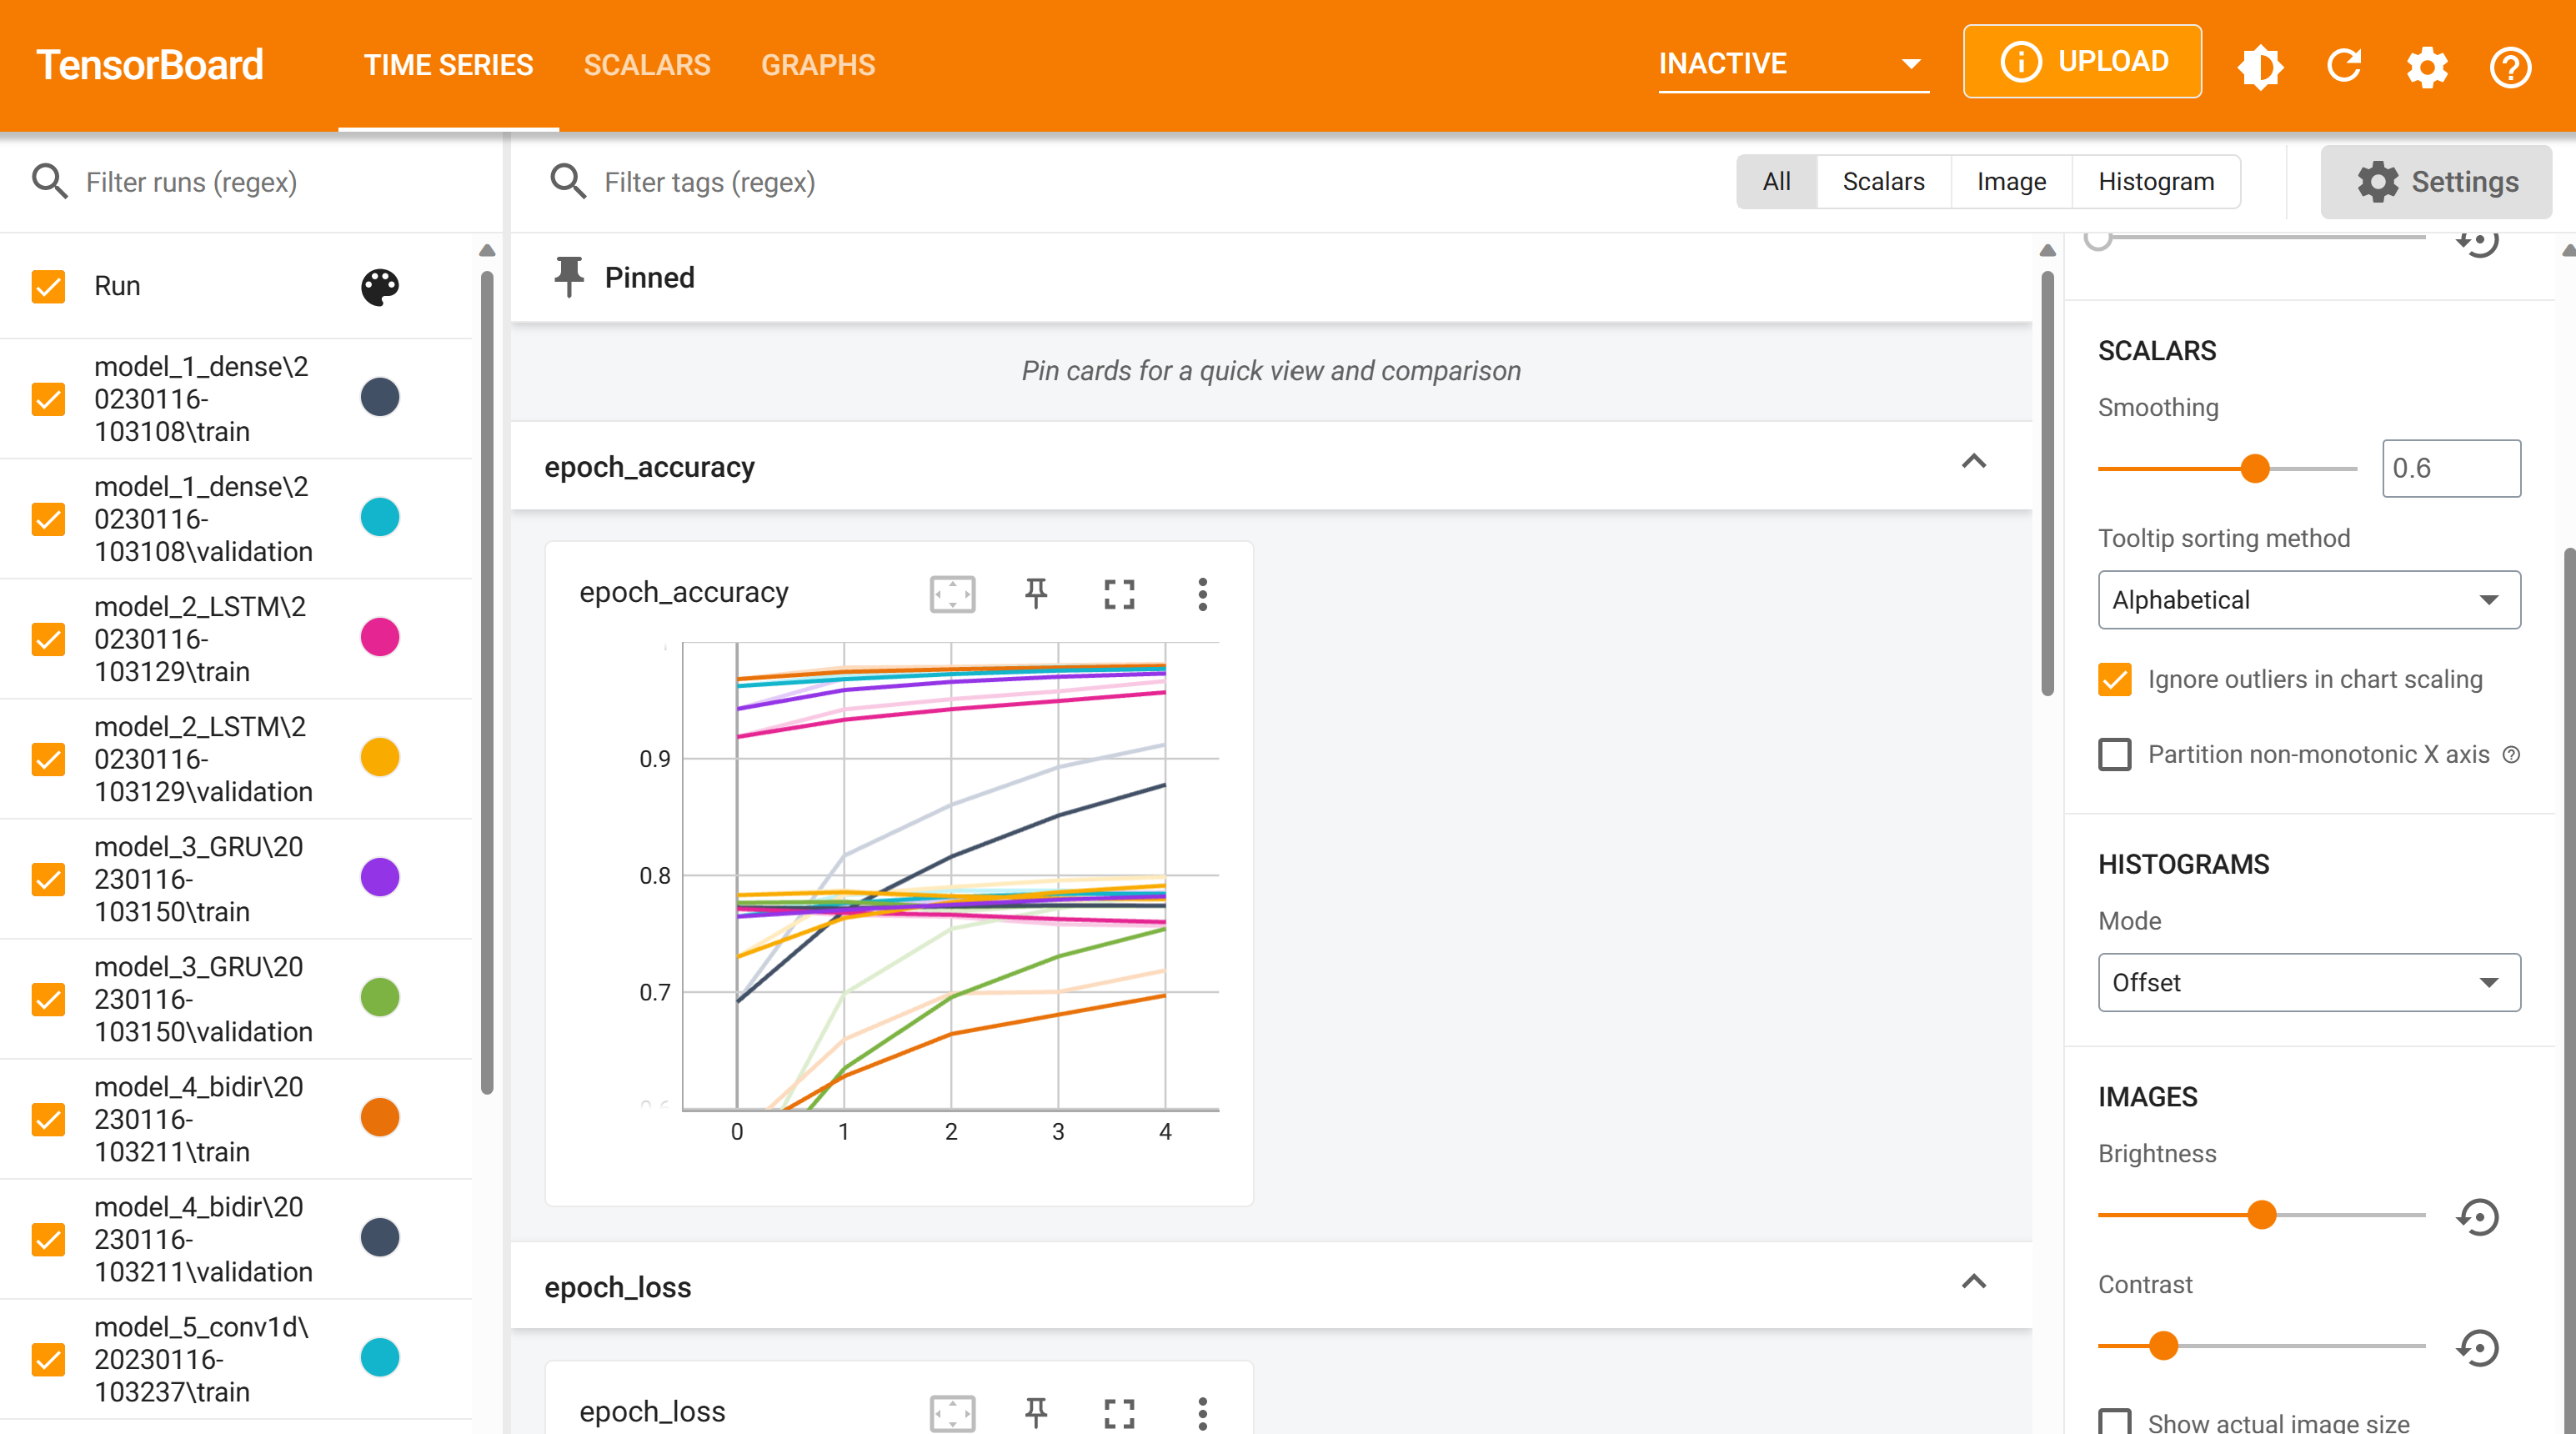

### Saving and loading models

In [97]:
# Saving TFHub's Sentence Encoder to HDF5 format
model_6.save("model_6.h5")

In [98]:
# Loading model back
import tensorflow_hub as hub

loaded_model_6 = tf.keras.models.load_model(
    "model_6.h5",
    custom_objects={"KerasLayer": hub.KerasLayer}
)